In [16]:
import matplotlib.pyplot as plt

import datetime

import pandas as pd

import numpy as np

import yfinance as yfin

import tensorflow as tf
from tensorflow import Variable
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import keras.losses as ks
from scikeras.wrappers import KerasRegressor


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose


from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [3]:
# gestione dei valori NULL
def handling_null_values(df):
    if df.isnull().sum()['Adj Close'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['Adj Close'] = imputer.fit_transform(df['Adj Close'].values.reshape(-1, 1))

    if df.isnull().sum()['Close'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['Close'] = imputer.fit_transform(df['Close'].values.reshape(-1, 1))
    
    if df.isnull().sum()['Open'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['Open'] = imputer.fit_transform(df['Open'].values.reshape(-1, 1))
    
    if df.isnull().sum()['High'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df ['High'] = imputer.fit_transform(df['High'].values.reshape(-1, 1))
                                                
    if df.isnull().sum()['Low'] != 0:
        imputer = KNNImputer(n_neighbors=2)
        df['Low'] = imputer.fit_transform(df['Low'].values.reshape(-1, 1))

    if df.isnull().sum()['Volume'] != 0:
        imputer = KNNImputer (n_neighbors=2)
        df['Volume'] = imputer.fit_transform(df['Volume'].values.reshape(-1, 1))

    return df

In [4]:
# top 30 U.S. companies by market capitalization
# except ABBV, FB, TSLA: listed after 2009-12-31
tickers = ['AAPL', 'MSFT', 'CSCO', 'AMZN', 'BRK-A', 'NVDA', 'V', 'JPM', 'UNH', 
           'JNJ']
     

start_time = datetime.datetime(2009, 12, 31) # 2009-12-31
end_time = datetime.datetime(2021, 12, 31) # 2021-12-31
time_step = 100
     

# where to split training and validation datasets
all_split = 2517 # start 31/12/2009, val 02/01/2020, end 31/12/2021
# abbv_split = 1762 # start 02/01/2013
# fb_split = 1917 # start 18/05/2012
# tsla_split = 2394 # start 29/06/2010
  

# getting datetimeindex
df = yfin.download(tickers[0], start_time, end_time)
df.index = pd.to_datetime(df.index)

# dataframe for Adj Close price
act_adj_close_df = pd.DataFrame(index=df.index, columns=tickers)
for ticker in tickers:
    stock_price_df = yfin.download(ticker, start_time, end_time)
    stock_price_df.index = pd.to_datetime(stock_price_df.index)
    handling_null_values(stock_price_df)
    act_adj_close_df[ticker] = stock_price_df['Adj Close']
     

act_adj_close_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,MSFT,CSCO,AMZN,BRK-A,NVDA,V,JPM,UNH,JNJ
Date,,,,,,,,,,
2009-12-31,6.371569,23.075764,16.234898,6.7260,99200.0,4.283801,19.745792,28.651052,24.648184,42.472588
2010-01-04,6.470742,23.431593,16.743507,6.6950,99600.0,4.240230,19.899321,29.497791,25.497284,42.650623
2010-01-05,6.481928,23.439157,16.668913,6.7345,99710.0,4.302147,19.671288,30.069149,25.456852,42.156063
2010-01-06,6.378825,23.295309,16.560406,6.6125,99850.0,4.329666,19.407137,30.234356,25.707542,42.498955
2010-01-07,6.367032,23.053045,16.635000,6.5000,100000.0,4.244818,19.587755,30.833277,26.694111,42.195637


### 1. Controllo stazionarità della serie per ARIMA

In [12]:
# controllo stazionarità della serie
def check_stationarity(df):
   

    print('Risultati del test dickey fuller')
    result = adfuller(df)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


In [13]:
# una serie è stazionaria quando p<0.05 e i valori critci si avvicinano a ADF Statistic, quindi capisco che non lo è
check_stationarity(act_adj_close_df['AAPL'])

Risultati del test dickey fuller
ADF Statistic: 3.5540623493504424
p-value: 1.0
Critical Values:
	1%: -3.432536741492438
	5%: -2.862506160743024
	10%: -2.5672843129045173


In [14]:
act_adj_close_sq_df = np.log(act_adj_close_df)

In [15]:
# i valori sono migliorati adesso 
check_stationarity(act_adj_close_sq_df['AAPL'])

Risultati del test dickey fuller
ADF Statistic: -0.036688076520866364
p-value: 0.9553907816084053
Critical Values:
	1%: -3.4325272764323667
	5%: -2.862501980355106
	10%: -2.567282087313508


In [38]:
# controllo che la serie non abbia stagionalità
def make_decomposition(df):
    df.reset_index(drop=True)
    result = seasonal_decompose(df, model='multiplicative', period=30)
    result.plot()
    plt.show

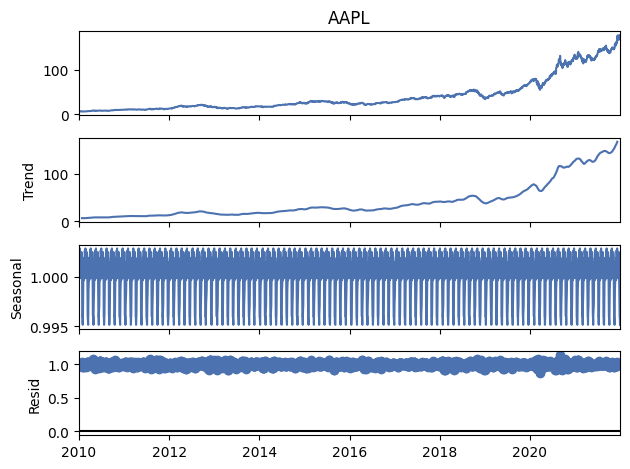

In [39]:
# i valori sono periodici quindi non ha stagionalità
make_decomposition(act_adj_close_df['AAPL'])

### 2. GridSearch modello LSTM

In [4]:
def dataset_train_creation(train_data, time_steps):
    x_data = []
    y_data = []
    for i in range(time_steps, len(train_data)):
        x_data.append(train_data[i - time_steps: i, 0])
        y_data.append(train_data[i, 0])
    return np.array(x_data), np.array(y_data)

In [5]:
def dataset_test_creation(total_dataset, time_steps, train_data):
    test_data_adjusted = total_dataset[len(train_data) - time_steps:, :]
    x_data = []
    for i in range(time_steps, len(test_data_adjusted)):
        x_data.append(test_data_adjusted[i - time_steps: i, 0])
    return np.array(x_data)

In [6]:
def create_model(time_steps=1, neurons=100, activation='relu', optimizer='adam', dropout_rate=0.0):
    model = Sequential(name="RNN_model")
    model.add(LSTM(units=neurons, activation=activation, return_sequences=False, input_shape=(time_steps, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    return model

In [8]:
# normalizzazione dell'intero insieme dei dati
scaler = MinMaxScaler(feature_range=(0,1))

data_scaled = scaler.fit_transform(np.array(act_adj_close_df[ticker]).reshape(-1,1))

train, test = data_scaled[:all_split], data_scaled[all_split:]

train_data = data_scaled[0: len(train), :]
test_data = data_scaled[len(train): len(data_scaled), :]

time_steps = 1

x_train, y_train = dataset_train_creation(train_data=train_data, time_steps=time_steps)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_test = dataset_test_creation(total_dataset=data_scaled, time_steps=time_steps, train_data=train_data)
y_test = np.array(test_data)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# valori che verranno provati sul modello    
batch_size = [16, 24, 32]
epochs = [100, 150, 200]
neurons = [50, 100]
dropout_rate = [0.0, 0.2]
param_grid = dict(batch_size=batch_size, epochs=epochs, model__neurons=neurons, model__dropout_rate=dropout_rate)

model = KerasRegressor(model=create_model, verbose=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)
    
# stampo i risultati del gridsearch
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    


C:\Users\fanta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/200
105/105 [==============================] - 4s 5ms/step - loss: 0.0693 - mse: 0.0693
Epoch 2/200
105/105 [==============================] - 1s 5ms/step - loss: 0.0177 - mse: 0.0177
Epoch 3/200
105/105 [==============================] - 1s 5ms/step - loss: 0.0081 - mse: 0.0081
Epoch 4/200
105/105 [==============================] - 1s 5ms/step - loss: 0.0018 - mse: 0.0018
Epoch 5/200
105/105 [==============================] - 1s 5ms/step - loss: 2.7398e-04 - mse: 2.7398e-04
Epoch 6/200
105/105 [==============================] - 0s 5ms/step - loss: 1.5955e-04 - mse: 1.5955e-04
Epoch 7/200
105/105 [==============================] - 1s 5ms/step - loss: 1.4750e-04 - mse: 1.4750e-04
Epoch 8/200
105/105 [==============================] - 1s 5ms/step - loss: 1.4106e-04 - mse: 1.4106e-04
Epoch 9/200
105/105 [==============================] - 1s 5ms/step - loss: 1.3609e-04 - mse: 1.3609e-04
Epoch 10/200
105/105 [==============================] - 1s 5ms/step - loss: 1.3165e-04 - mse: 1.